In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.linalg import lstsq
import scipy.optimize as opt

sns.set(color_codes=True)
mpl.rcParams['figure.dpi'] = 120

In [2]:
df1 = pd.read_csv('Канал 1_800nm_0.2.csv', delimiter=';')
df1.columns = ['мВ', 'мА']
df2 = pd.read_csv('Канал 2_800nm_0.2.csv', delimiter=';')
df2.columns = ['мВ', 'мА']

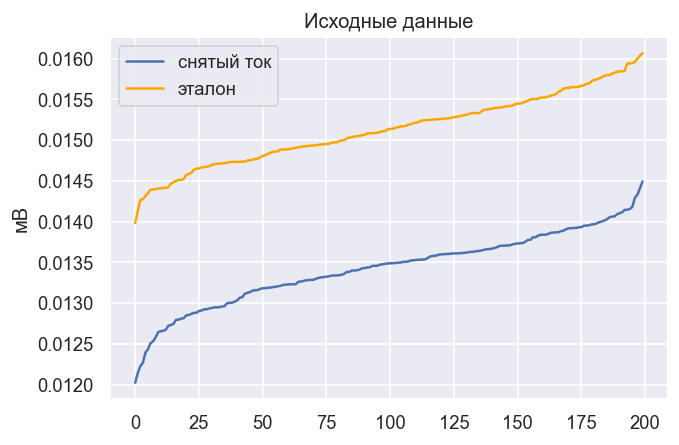

In [3]:
plt.title('Исходные данные')

plt.plot(df1['мВ'], label='снятый ток', color='b')
plt.plot(df2['мВ'], label='эталон', color='orange')
plt.legend()
plt.ylabel('мВ')
plt.show()

In [4]:
eps = 1e-4

In [5]:
df1['infV'] = df1['мВ'] - eps
df1['supV'] = df1['мВ'] + eps

df2['infV'] = df2['мВ'] - eps
df2['supV'] = df2['мВ'] + eps

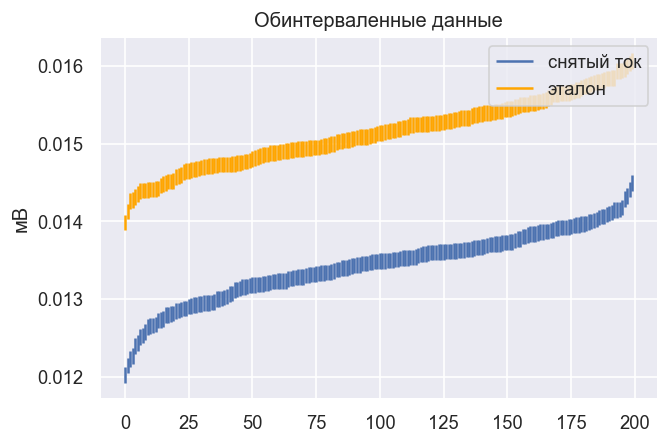

In [6]:
plt.title('Обинтерваленные данные')

plt.vlines(np.arange(len(df1)), df1['infV'], df1['supV'], label='снятый ток', colors='b')
plt.vlines(np.arange(len(df2)), df2['infV'], df2['supV'], label='эталон', colors='orange')

plt.legend()
plt.ylabel('мВ')

plt.show()

In [7]:
x = np.arange(len(df1))
A = np.vstack([x, np.ones(len(x))]).T

In [8]:
sol1 = lstsq(A, df1['мВ'])[0]
sol2 = lstsq(A, df2['мВ'])[0]

mnk1 = sol1[0] * x + sol1[1]
mnk2 = sol2[0] * x + sol2[1]

<ipython-input-8-056569733eaf>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol1 = lstsq(A, df1['мВ'])[0]
<ipython-input-8-056569733eaf>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol2 = lstsq(A, df2['мВ'])[0]


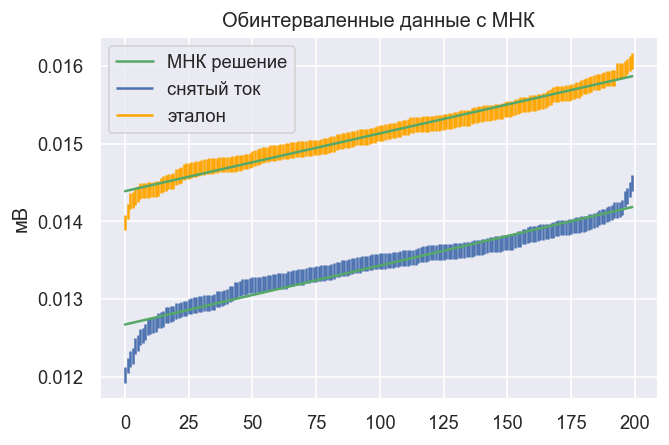

In [9]:
plt.title('Обинтерваленные данные с МНК')

plt.vlines(np.arange(len(df1)), df1['infV'], df1['supV'], label='снятый ток', colors='b')
plt.plot(x, mnk1, c='g')

plt.vlines(np.arange(len(df2)), df2['infV'], df2['supV'], label='эталон', colors='orange')
plt.plot(x, mnk2, c='g' ,label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

In [10]:
w1 = []
for pred, tg in zip(mnk1, df1['мВ']):
    w1.append(max(abs(pred-tg) / eps, 1))
w1 = np.array(w1)

w2 = []
for pred, tg in zip(mnk2, df2['мВ']):
    w2.append(max(abs(pred-tg) / eps, 1))
w2 = np.array(w2)

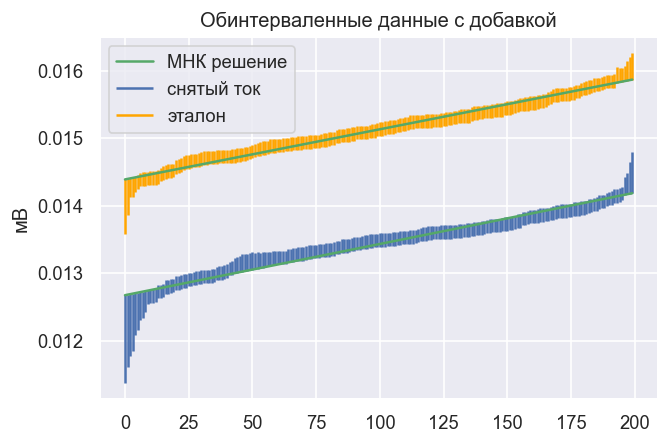

In [11]:
plt.title('Обинтерваленные данные с добавкой')

plt.vlines(x, df1['мВ']-[i*eps for i in w1], df1['мВ']+[i*eps for i in w1], label='снятый ток', colors='b')
plt.plot(x, mnk1, c='g')

plt.vlines(x, df2['мВ']-[i*eps for i in w2], df2['мВ']+[i*eps for i in w2], label='эталон', colors='orange')
plt.plot(x, mnk2, c='g',label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

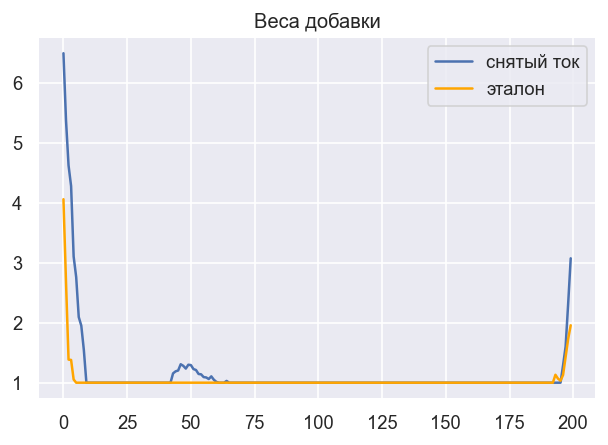

In [12]:
plt.title('Веса добавки')
plt.plot(w1, label='снятый ток', color='b')
plt.plot(w2, label='эталон', color='orange')
plt.legend()

plt.show()

In [13]:
h_mnk1 = mnk1 - sol1[1]
h_mnk2 = mnk2 - sol2[1]

In [14]:
df1['infI'] = df1['мВ'] - [i*eps for i in w1] - h_mnk1
df1['supI'] = df1['мВ'] + [i*eps for i in w1] - h_mnk1

df2['infI'] = df2['мВ'] - [i*eps for i in w2] - h_mnk2
df2['supI'] = df2['мВ'] + [i*eps for i in w2] - h_mnk2

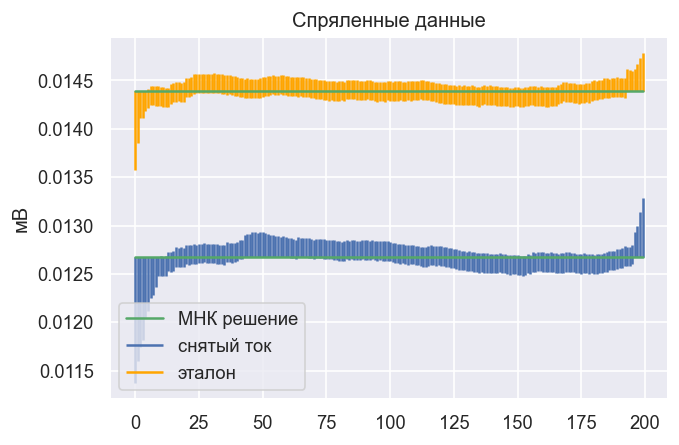

In [15]:
plt.title('Спряленные данные')

plt.vlines(x, df1['infI'], df1['supI'], label='снятый ток', colors='b')
plt.plot(x, [sol1[1] for _ in x], c='g')

plt.vlines(x, df2['infI'], df2['supI'], label='эталон', colors='orange')
plt.plot(x, [sol2[1] for _ in x], c='g', label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

In [16]:
def JK(R):
    sup2 = df2['supI'].tolist()
    inf2 = df2['infI'].tolist()
    
    sup1 = (df1['supI'] * R).tolist()
    inf1 = (df1['infI'] * R).tolist()
    
    nom = min(min(sup1), min(sup2)) - max(max(inf1), max(inf2))
    denom = max(max(sup1), max(sup2)) - min(min(inf1), min(inf2))
    
    return nom / denom

In [17]:
jk = []
r = np.arange(1, 1.5001, .0001)
for i in r:
    jk.append(JK(i))
    
res = opt.fmin(lambda x: -JK(x), 1)[0]

Optimization terminated successfully.
         Current function value: 0.000135
         Iterations: 13
         Function evaluations: 26


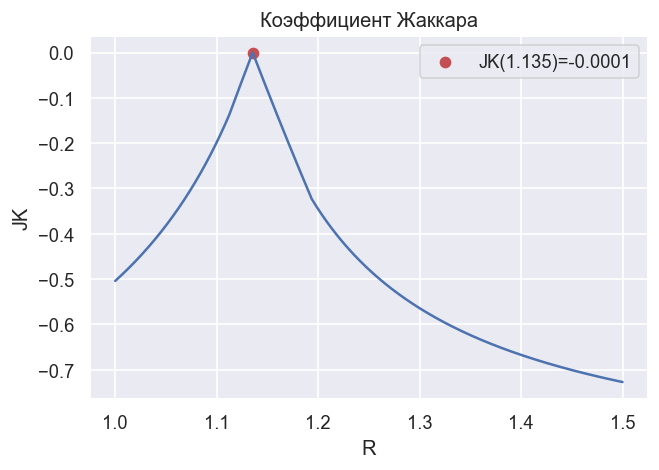

In [18]:
plt.title('Коэффициент Жаккара')
plt.plot(r, jk)
plt.scatter([res], [JK(res)], c='r', label='JK('+'{:.3f}'.format(res)+')=' +'{:.4f}'.format(JK(res)))
plt.xlabel('R')
plt.ylabel('JK')
plt.legend()

plt.show()